In [2]:
from sklearn.model_selection import GridSearchCV
from stochastic.processes.continuous import BrownianMotion
import torch.nn.functional as F
from torch import optim,nn
import torch

from scipy.stats import norm
import pandas as pd
import numpy as np
import random

from tqdm import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Simulate 1000 Brownian Motions
Generate 1000 Brownian Motion processes with increment of 1e-3.                
W --> shape (1000, 1000), i.e.  `NumIncre`*`NumBM`                
> It is way more efficient to generate BMs by package.

Training And Testing Set:

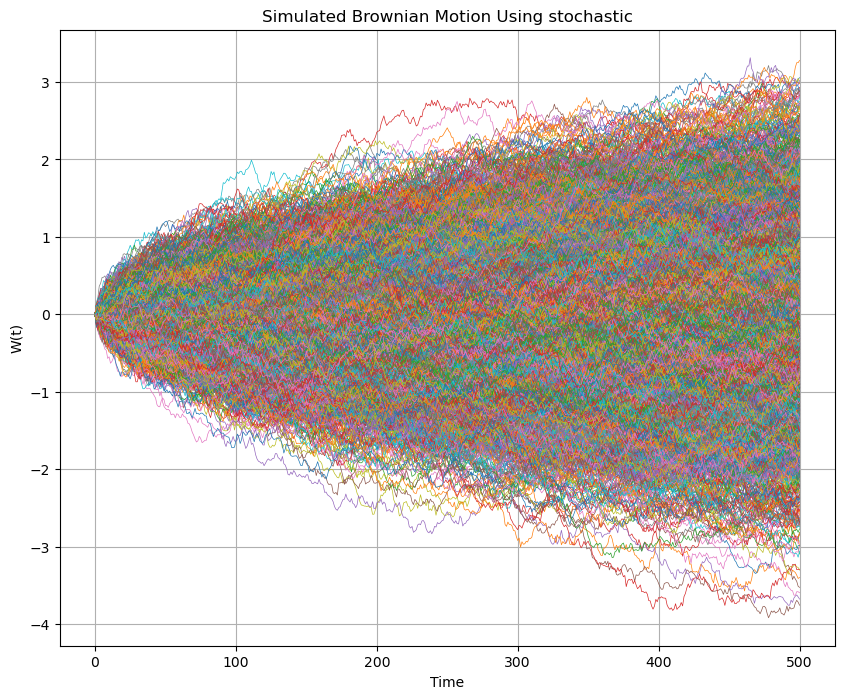

In [3]:
NT=500
dt = 1/NT
NumBM=5000

dW = np.sqrt(dt) * np.random.randn(int(NumBM),int(NT)+1)
dW[:,0]=np.zeros((int(NumBM)))
W=dW.cumsum(axis=1)
dW=torch.FloatTensor(dW)
'''=============================================================='''
# W=pd.read_csv("BM.csv",index_col=0)
# Plot it
plt.figure(figsize=(10,8))
plt.subplot()
plt.plot(W.T,linewidth=0.5)
plt.title("Simulated Brownian Motion Using stochastic")
plt.xlabel("Time")
plt.ylabel("W(t)")
plt.grid()

## Divide training and testing sets
NumTrain=4000
dW_train= dW[:NumTrain,:]
dW_test= dW[NumTrain:,:]
W_train=W[:NumTrain,:]
W_test=W[NumTrain:,:]

## Neural Network
$\begin{cases} X_{t_i}-X_{t_{i-1}} &=Y_{t_{i-1}}(t_i-t_{i-1})+\sigma (W_{t_i}-W_{t_{i-1}}),\, &X_0=x \\ Y_{t_i}-Y_{t_{i-1}} &= Z_{t_{i-1}}(W_{t_i}-W_{t_{i-1}}),\, &Y_T=-g'(X_T^{0,x})\end{cases}$

$ \therefore \begin{cases} X_T&=x+\sum_{i=1}^N{Y_{t_{i-1}}(t_i-t_{i-1})}+\sigma W_T \\ Y_T&=Y_0+\sum_i^N{ Z_{t_{i-1}}(W_{t_i}-W_{t_{i-1}})} \end{cases}$, where $Y_0, Z_{t_0}, Z_{t_1}, ..., Z_{t_{N-1}}$ are parameters.    

The Loss Function is: $ \mathcal{L}=\frac{1}{NumBM}\sum_{i=1}^{NumBM} {({Y_T}_i+g'(X_t^{0,x}))^2} $

So the process $(Z_{t})_{t \ge 0}$ might have no closed form, but only numerical approximations on the time partition.                   



### The Simplest Case: 1D + Uncoupled FBSDE
                                   
Let $g(x)=x^2$ and $\sigma=1$, then $a_T=-2X_t^{0,x}$ , and:                  
$\begin{cases} X_{t_i}-X_{t_{i-1}} &=(W_{t_i}-W_{t_{i-1}}),\, &&X_0=x \\ Y_{t_i}-Y_{t_{i-1}} &= Z_{t_{i-1}}(W_{t_i}-W_{t_{i-1}}),\, &&a_T=-g'(X_T^{0,x})=-2X_T^{0,x}\end{cases}$

$ \therefore \begin{cases} X_{t_i}&=x+W_{t_i} \\ Y_{t_i}&=a_0+\sum_{j=1}^i{ Z_{t_{j-1}}(W_{t_j}-W_{t_{j-1}})} \end{cases}$, where $Y_0, Z_{t_0}, Z_{t_1}, ..., Z_{t_{i-1}}$ are parameters.                

The gradient of loss function w.r.t. $Y_0$ is: $\triangledown_{Y_0} \mathcal{L} =\frac{2}{NumBM}\sum{(Y_T+2X_T)*1}$                  
The gradient w.r.t. __Z__ is: $\triangledown_{Z}\mathcal{L}= \frac{2}{NumBM}\sum{(Y_T+2X_T)(\Delta W)}$
                  

### Manually Solve By GD
So simply by Gradient Descent, we can approximate the solution by 4000 iterations, with the learning rate of 0.7.

<Axes: title={'center': 'Traing'}>

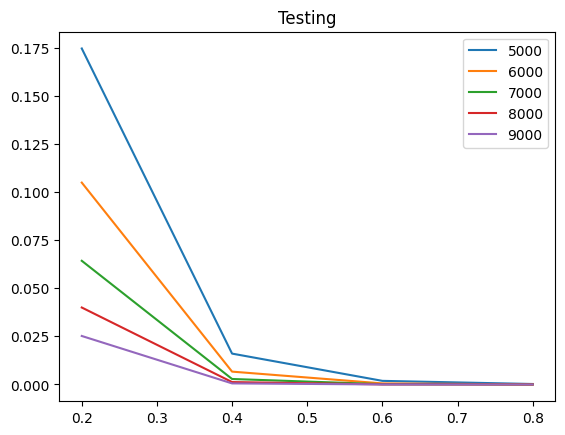

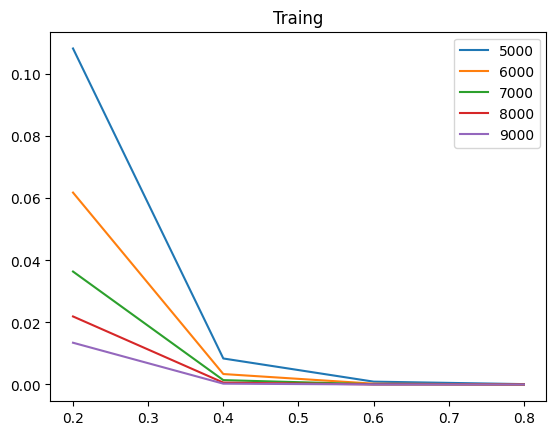

In [4]:
## Train
def GD_solver(MaxIter,dW_train,dW_test,learning_rate,verbose):
    y0=0
    z=np.zeros(shape=(1,NT))
    
    for i in range(MaxIter): 
        
        ## propagate forward
        
        yT=y0+np.dot(dW_train[:,1:],z.T) 
        XT=W_train[:,-1].reshape(-1,1)
        
        ## GD
        # print(yT.shape,XT.shape)
        y0-=learning_rate*np.mean(yT+2*XT)
        # print((yT+2*XT).shape,yT.shape,XT.shape)
        z-=learning_rate*np.mean((yT+2*XT)*dW_train[:,1:] ,axis=0,keepdims=True)
        
        cost=np.mean(np.power(yT+2*XT,2))
        ## print
        # if verbose==True & (i+1)%(MaxIter//10)==0:
        #     print(verbose)
        #     print("Loss @ {}th iteration: {:.6f}".format(i+1,cost))
    XT_te=W_test[:,-1].reshape(-1,1)
    yT_te=y0+np.dot(dW_test[:,1:],z.T)
    mse_te=np.mean(np.power(yT_te+2*XT_te,2))
    return cost, mse_te, {'y0':y0,'z':z}


# learning_rate=0.7
# MaxIter=4000   # No. of iterations

MSE_tr={}
MSE_te={}
params={}
MaxIters=np.arange(5000,10000,1000)
learning_rates=np.arange(0.2,1,0.2)
for MaxIter in MaxIters:
    MSE_tr[MaxIter]=[]
    MSE_te[MaxIter]=[]
    for learning_rate in learning_rates:
        mse_tr,mse_te,_=GD_solver(MaxIter=MaxIter,dW_train=dW_train.numpy(),dW_test=dW_test.numpy(),learning_rate=learning_rate,verbose=False)
        MSE_tr[MaxIter].append(mse_tr)
        MSE_te[MaxIter].append(mse_te)
MSE_tr=pd.DataFrame(MSE_tr,index=learning_rates)
MSE_te=pd.DataFrame(MSE_te,index=learning_rates)
MSE_te.plot(title='Testing')
MSE_tr.plot(title='Traing')

MSE_tr: 0.0002614112331828936
MSE_te: 0.0005529808308596388



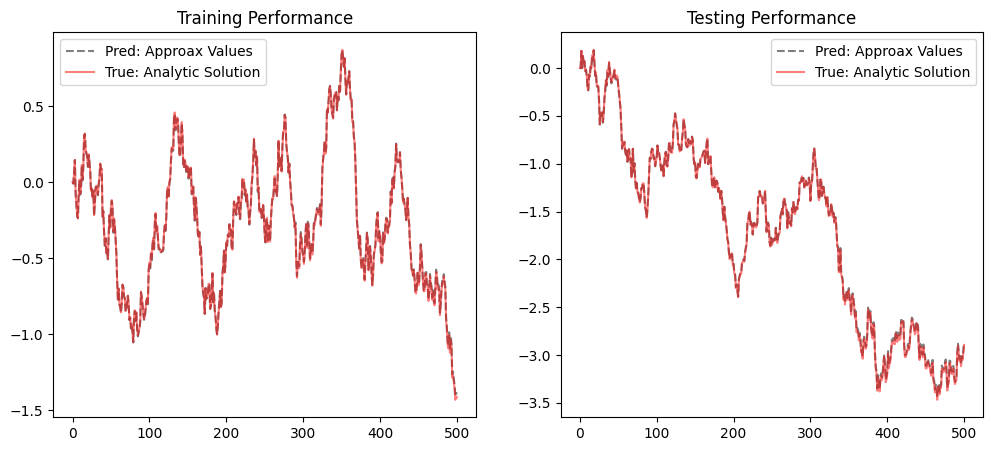

In [5]:
## Plot results
mse_tr,mse_te,params=GD_solver(MaxIter=6000,dW_train=dW_train.numpy(),dW_test=dW_test.numpy(),learning_rate=0.6,verbose=True)
print("MSE_tr: {}\nMSE_te: {}\n".format(mse_tr,mse_te))
y0=params['y0']
z=params['z']
idx=2 ## index for the selected path for visualizatino
y_train=[y0]
y_test=[y0]
z=z.reshape(-1)
for i in range(1,NT+1):
    y_train.append(y_train[i-1]+(z[i-1]*dW_train[idx,i]))
    y_test.append(y_test[i-1]+(z[i-1]*dW_test[idx,i]))

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(y_train, color="black", linestyle='--',alpha=0.5,label="Pred: Approax Values")
plt.plot(-2*W_train[idx,:], color="red", alpha=0.5,label="True: Analytic Solution")
plt.title("Training Performance")
plt.legend()
 
plt.subplot(122)
plt.plot(y_test, color="black", linestyle='--',alpha=0.5,label="Pred: Approax Values")
plt.plot(-2*W_test[idx,:], color="red", alpha=0.5,label="True: Analytic Solution")
plt.title("Testing Performance")
plt.legend()


## TODO: text(MSE_te)

## Decoupled: By NN
500 Smples * 80 Partitions

150 Batches * 25 OptimSteps

*Note*:
> `OptimSteps` is linearly related to the error per step, when `OptimSteps`<200.



In [86]:
## Build Network Class for FBSDE
#Numbers
NumTrain=500
NT=80
dt=1/NT
sigma=0.05
#Forward Loss
forward_losses = []
class Network(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_outputs):
        '''
        lr: learning rate
        input_dims, fc1_dims, fc2_dims, n_outputs: nodes (functions) in each layer.
        '''
        super(Network, self).__init__()

        #Pass input parameters
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_out = n_outputs

        #Construct network
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_out)
        nn.init.xavier_uniform_(self.fc3.weight)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x= F.relu(self.fc2(x))
        output = self.fc3(x)
        return output

In [87]:
class plot_results():
    def __init__(self,loss=forward_losses,sigma=sigma,Npaths=100,NumTrain=NumTrain,NT=NT):
        self.loss=loss
        self.x_path,self.y_path=get_target_path_coupled(dB, init_x, y0_model=y0_model_main, z_models=z_models_main, NumBM=NumTrain, NT=NT)
        self.number_of_paths=np.minimum(Npaths,NumTrain)
        self.sigma=sigma
    
    def FwdLoss(self,log=True):
        plt.figure(figsize=(10,6))
        plt.title("Forward_Loss vs Batch",fontsize=18)
        plt.plot(self.loss)

        if log==True:
            plt.yscale('log')

    def results(self,seed=0):
        random.seed(seed)
        idx_list = np.random.choice(NumTrain, self.number_of_paths, replace = False)
        x_plot = self.x_path.detach().numpy()[idx_list]
        y_plot = self.y_path.detach().numpy()[idx_list]
        t = np.array([i for i in range(NT+1)]) * 1/(NT)
        plt.figure(figsize=(20,6))
        plt.subplot(121)
        for i in range(self.number_of_paths):
                plt.plot(t,x_plot[i], color="blue", alpha=0.5)
        plt.title("X")

        plt.subplot(122)
        for i in range(self.number_of_paths):
                plt.plot(t,y_plot[i], color="red", alpha=0.5)
        plt.title("Y Values")

        ### Integrated Plots
        random.seed(seed)
        idx=random.randint(0,self.number_of_paths)
        plt.figure(figsize=(10,8))
        plt.subplot()
        plt.plot(t,x_plot[idx], color="blue", alpha=0.5,label='X')
        plt.plot(t,y_plot[idx], color="black", linestyle='--',alpha=0.5,label="Y Values")
        plt.hlines(y=[0,1],xmin=0,xmax=1,colors='firebrick',linestyles='-.')
        plt.title("Comparison of A Particular Path")
        plt.legend()
    
    def qq_plot(self,sigma=sigma):
        plt.figure()
        plt.title("QQ-Plot")
        x_sigmoid=1/(1+np.exp(self.x_path[:,-1]/sigma))
        plt.scatter(x_sigmoid,self.y_path[:,-1],s=3)
        plt.plot(np.linspace(0,1,5),np.linspace(0,1,5),linestyle='--',linewidth=1,color='r')

In [5]:
## Train
def Sample_Init(N):
    '''
    Generate N samples of x0
    '''
    xi = np.random.normal(0,0.1,size=N)

    return torch.FloatTensor(xi).view(-1,1)

def SampleBMIncr(T, Npaths, Nsteps):
    # Returns Matrix of Dimension Npaths x Nsteps With Sample Increments of of BM
    # Here an increment is of the form dB
    dt = T / Nsteps
    dB = np.sqrt(dt) * np.random.randn(Npaths, Nsteps)
    return torch.FloatTensor(dB)

def g_prime(x):
    gp =  2 * x   ## REVISE: NOT -2*x
    return gp

# Forward Loss
def get_foward_batch_loss(dB, init_x,NT, gp,y0_model, z_models):
    x =  init_x
    y = y0_model(x)
    for j in range(1, NT+1):
 
        z = z_models[j-1](x)
        x = x  + dB[:,j].view(-1,1)
        y = y  + z * dB[:,j].view(-1,1)
    return torch.mean((y + gp(x))**2)   ## REVISE: target is -g_prime, so '+'


def get_target_path(dB, init_x,NumBM, NT,y0_model, z_models):
    x_path = torch.ones(NumBM,NT+1)
    y_path = torch.ones(NumBM,NT+1)
    x = init_x
    y = y0_model(x)
    x_path[:,0] = x.squeeze()
    y_path[:,0] = y.squeeze()
    for j in range(1, NT+1):
        z = z_models[j-1](x)
        x = x  + dB[:,j].view(-1,1)
        y= y + z * dB[:,j].view(-1,1)
        x_path[:,j] = x.squeeze()
        y_path[:,j] = y.squeeze()
    return x_path.detach(), y_path.detach()


#Numbers
NumTrain=500
NT=80
dt=1/NT
dB = SampleBMIncr(1, Npaths=NumTrain, Nsteps=NT+1)
init_x =  Sample_Init(N=NumTrain)

#Set up main models for y0 and z (z will be list of models)
layer_dim = 10
y0_model_main = Network(lr=0.001, input_dims=[1], fc1_dims=layer_dim, fc2_dims=layer_dim,
                     n_outputs=1)
z_models_main = [Network(lr=0.001, input_dims=[1], fc1_dims=layer_dim, fc2_dims=layer_dim,
                     n_outputs=1) for i in range(NT)]

##Input Parameters for Optimization
forward_losses = []

#How many batches?
MaxBatch= 150

#How many optimization steps per batch
OptimSteps= 25

#Set Learning rate
learning_rate = 0.001

#Train on a single batch?
single_batch = True

#Set seed
random.seed(100)

#Define optimization parameters
params = list(y0_model_main.parameters())
for i in range(NT):
    params += list(z_models_main[i].parameters())
    
#Set up optimizer and scheduler
optimizer = optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.999)


for k in range(0,MaxBatch):

    print("Batch Number: ", k+1)
    sloss=0
    #optimize main network wrt the foward loss
    for l in range(0,OptimSteps):
        optimizer.zero_grad()

        loss = get_foward_batch_loss(dB, init_x,NT=NT,gp=g_prime, y0_model=y0_model_main, z_models=z_models_main)

        loss.backward()
        optimizer.step()
        scheduler.step()
        nloss = loss.detach().numpy()
        sloss += nloss
        # print('OptimStep: '+ str(l+1))
        # print('forward_loss: ' + str(nloss))
    avgloss = sloss/OptimSteps
    print("Average Error Est: ", avgloss)
    forward_losses.append(avgloss)

    #Generate a new batch if using multiple batches
    if(not single_batch):
        dB = SampleBMIncr(1, Npaths=NumTrain, Nsteps=NT+1)
        init_x =  Sample_Init(N=NumTrain)

Batch Number:  1
Average Error Est:  3.801287851333618
Batch Number:  2
Average Error Est:  2.753632011413574
Batch Number:  3
Average Error Est:  2.0010634326934813
Batch Number:  4
Average Error Est:  1.44481454372406
Batch Number:  5
Average Error Est:  1.0304101657867433
Batch Number:  6
Average Error Est:  0.7295374751091004
Batch Number:  7
Average Error Est:  0.5213834583759308
Batch Number:  8
Average Error Est:  0.3811914026737213
Batch Number:  9
Average Error Est:  0.29013258814811704
Batch Number:  10
Average Error Est:  0.22993164300918578
Batch Number:  11
Average Error Est:  0.18802123606204987
Batch Number:  12
Average Error Est:  0.156852707862854
Batch Number:  13
Average Error Est:  0.13203378170728683
Batch Number:  14
Average Error Est:  0.10711516827344894
Batch Number:  15
Average Error Est:  0.08435493260622025
Batch Number:  16
Average Error Est:  0.06692672148346901
Batch Number:  17
Average Error Est:  0.05383929505944252
Batch Number:  18
Average Error Est: 

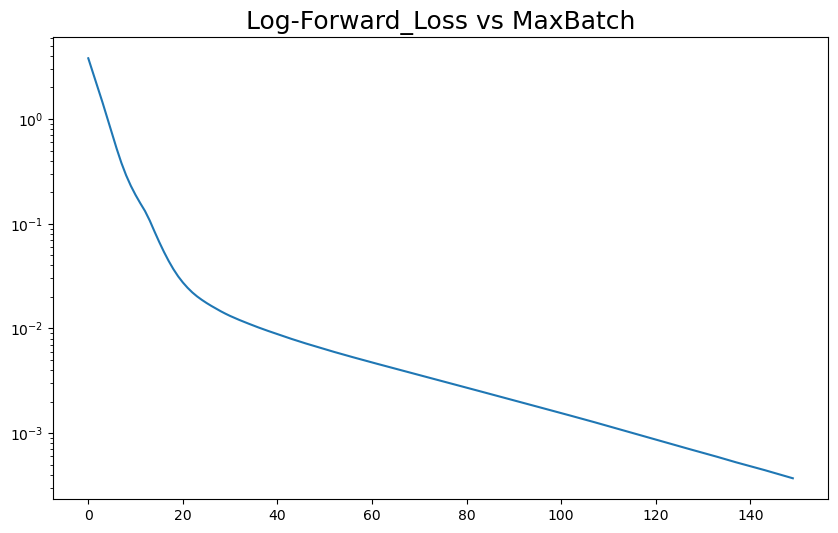

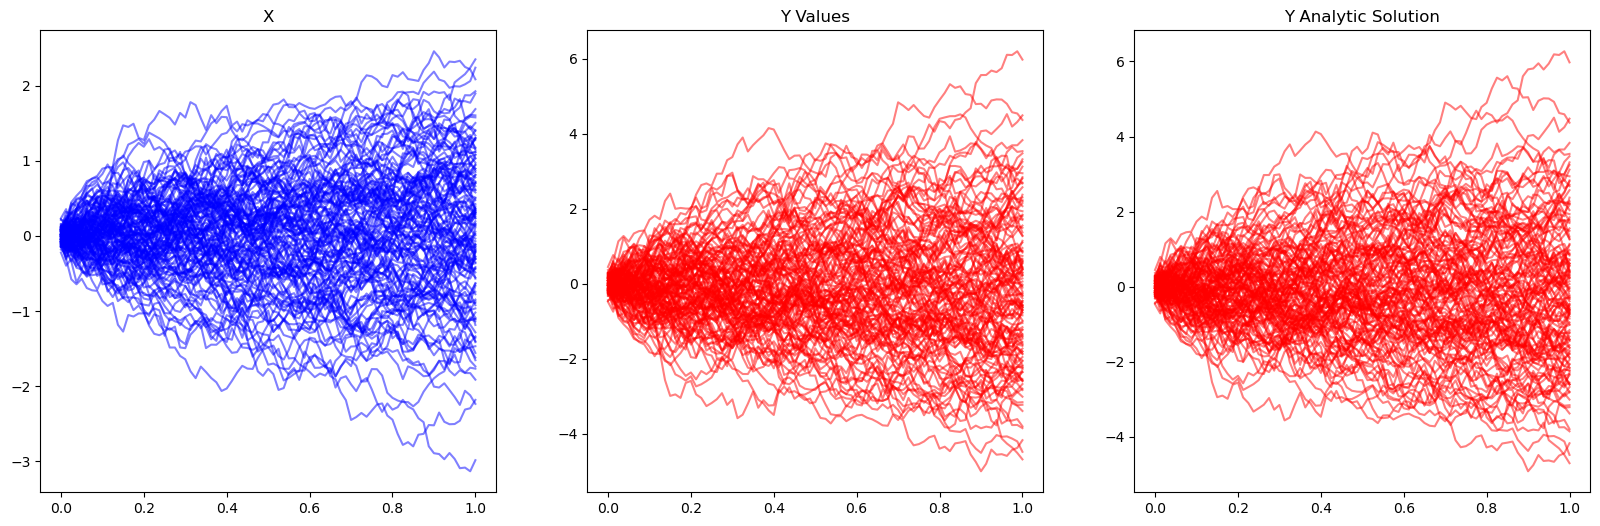

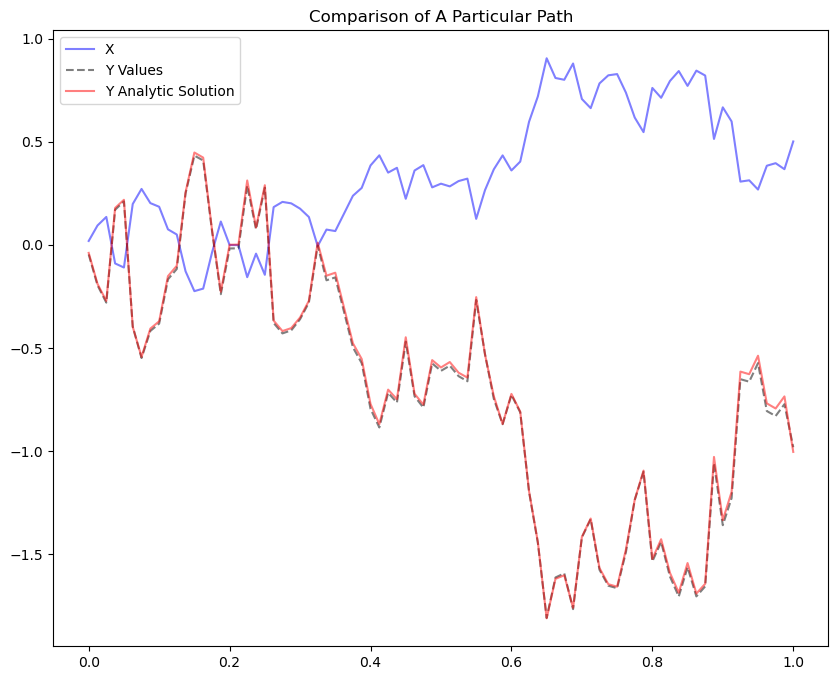

In [7]:
## Plot Results

#Log-Forward_loss
plt.figure(figsize=(10,6))
plt.title("Log-Forward_Loss vs MaxBatch",fontsize=18)
plt.plot(forward_losses)
plt.yscale('log')
x_path, y_path = get_target_path(dB, init_x, y0_model=y0_model_main, z_models=z_models_main, NumBM=NumTrain, NT=NT)
number_of_paths = np.minimum(128,NumTrain)
idx_list = np.random.choice(NumTrain, number_of_paths, replace = False)
x_plot = x_path.detach().numpy()[idx_list]
y_plot = y_path.detach().numpy()[idx_list]
y_plot_true=-g_prime(x_plot)
t = np.array([i for i in range(NT+1)]) * 1/(NT)

plt.figure(figsize=(20,6))
plt.subplot(131)
for i in range(number_of_paths):
        plt.plot(t,x_plot[i], color="blue", alpha=0.5)
plt.title("X")

plt.subplot(132)
for i in range(number_of_paths):
        plt.plot(t,y_plot[i], color="red", alpha=0.5)
plt.title("Y Values")

plt.subplot(133)
for i in range(number_of_paths):
        plt.plot(t,y_plot_true[i], color="red", alpha=0.5)
plt.title("Y Analytic Solution")


plt.figure(figsize=(10,8))
plt.subplot()
idx=1  ## index for the selected path for visualizatino
plt.plot(t,x_plot[idx], color="blue", alpha=0.5,label='X')
plt.plot(t,y_plot[idx], color="black", linestyle='--',alpha=0.5,label="Y Values")
plt.plot(t,y_plot_true[idx], color="red", alpha=0.5,label="Y Analytic Solution")
plt.title("Comparison of A Particular Path")
plt.legend()

## Coupled: By torch.nn
3000 Smples * 500 Partitions

20 Batches * 25 OptimSteps

$ \therefore \begin{cases} X_{t_i} &=x+\sum_{j=1}^i{Y_{t_{j-1}}(t_j-t_{j-1})} + W_{t_i} \\ Y_{t_i}&=Y_0+\sum_{j=1}^i{ Z_{t_{j-1}}(W_{t_j}-W_{t_{j-1}})} \end{cases}$, where $Y_0, Z_{t_0}, Z_{t_1}, ..., Z_{t_{i-1}}$ are parameters.  

In [8]:
## Train
def Sample_Init(N):
    '''
    Generate N samples of x0
    '''
    xi = np.random.normal(0,0.1,size=N)

    return torch.FloatTensor(xi).view(-1,1)

def SampleBMIncr(T, Npaths, Nsteps):
    # Returns Matrix of Dimension Npaths x Nsteps With Sample Increments of of BM
    # Here an increment is of the form dB
    dt = T / Nsteps
    dB = np.sqrt(dt) * np.random.randn(Npaths, Nsteps)
    return torch.FloatTensor(dB)

def g_prime(x):
    gp =  2 * x   ## REVISE: NOT -2*x
    return gp

# Forward Loss
def get_foward_loss_coupled(dB, init_x,NT, gp,y0_model, z_models):
    x =  init_x
    y = y0_model(x)
    for j in range(1, NT+1):
 
        z = z_models[j-1](x)
        x = x  + y*dt+ dB[:,j].view(-1,1)
        y = y  + z * dB[:,j].view(-1,1)
    return torch.mean((y + gp(x))**2)   ## REVISE: target is -g_prime, so '+'


def get_target_path_coupled(dB, init_x,NumBM, NT,y0_model, z_models):
    x_path = torch.ones(NumBM,NT+1)
    y_path = torch.ones(NumBM,NT+1)
    x = init_x
    y = y0_model(x)
    x_path[:,0] = x.squeeze()
    y_path[:,0] = y.squeeze()
    for j in range(1, NT+1):
        z = z_models[j-1](x)
        x = x  + y*dt+dB[:,j].view(-1,1)
        y= y + z * dB[:,j].view(-1,1)
        x_path[:,j] = x.squeeze()
        y_path[:,j] = y.squeeze()
    return x_path.detach(), y_path.detach()


#Numbers
NumTrain=500
NT=80
dt=1/NT
dB = SampleBMIncr(1, Npaths=NumTrain, Nsteps=NT+1)
init_x =  Sample_Init(N=NumTrain)

#Set up main models for y0 and z (z will be list of models)
layer_dim = 10
y0_model_main = Network(lr=0.001, input_dims=[1], fc1_dims=layer_dim, fc2_dims=layer_dim,
                     n_outputs=1)
z_models_main = [Network(lr=0.001, input_dims=[1], fc1_dims=layer_dim, fc2_dims=layer_dim,
                     n_outputs=1) for i in range(NT)]

##Input Parameters for Optimization
forward_losses = []

#How many batches?
MaxBatch= 150

#How many optimization steps per batch
OptimSteps= 25

#Set Learning rate
learning_rate = 0.001

#Train on a single batch?
single_batch = True

#Set seed
random.seed(100)

#Define optimization parameters
params = list(y0_model_main.parameters())
for i in range(NT):
    params += list(z_models_main[i].parameters())
    
#Set up optimizer and scheduler
optimizer = optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.999)


for k in range(0,MaxBatch):

    print("Batch Number: ", k+1)
    sloss=0
    #optimize main network wrt the foward loss
    for l in range(0,OptimSteps):
        optimizer.zero_grad()

        loss = get_foward_loss_coupled(dB, init_x,NT=NT,gp=g_prime, y0_model=y0_model_main, z_models=z_models_main)

        loss.backward()
        optimizer.step()
        scheduler.step()
        nloss = loss.detach().numpy()
        sloss += nloss
        # print('OptimStep: '+ str(l+1))
        # print('forward_loss: ' + str(nloss))
    avgloss = sloss/OptimSteps
    print("Average Error Est: ", avgloss)
    forward_losses.append(avgloss)

    #Generate a new batch if using multiple batches
    if(not single_batch):
        dB = SampleBMIncr(1, Npaths=NumTrain, Nsteps=NT+1)
        init_x =  Sample_Init(N=NumTrain)


Batch Number:  1
Average Error Est:  4.145209875106811
Batch Number:  2
Average Error Est:  2.5762223529815675
Batch Number:  3
Average Error Est:  1.6259075498580933
Batch Number:  4
Average Error Est:  1.0350793170928956
Batch Number:  5
Average Error Est:  0.6729113864898681
Batch Number:  6
Average Error Est:  0.4451602506637573
Batch Number:  7
Average Error Est:  0.29934449553489684
Batch Number:  8
Average Error Est:  0.20454960227012634
Batch Number:  9
Average Error Est:  0.14593767046928405
Batch Number:  10
Average Error Est:  0.10987658590078354
Batch Number:  11
Average Error Est:  0.08670621365308762
Batch Number:  12
Average Error Est:  0.0696728865802288
Batch Number:  13
Average Error Est:  0.05476545363664627
Batch Number:  14
Average Error Est:  0.0429987807571888
Batch Number:  15
Average Error Est:  0.035070457458496095
Batch Number:  16
Average Error Est:  0.02975914366543293
Batch Number:  17
Average Error Est:  0.02443983927369118
Batch Number:  18
Average Error

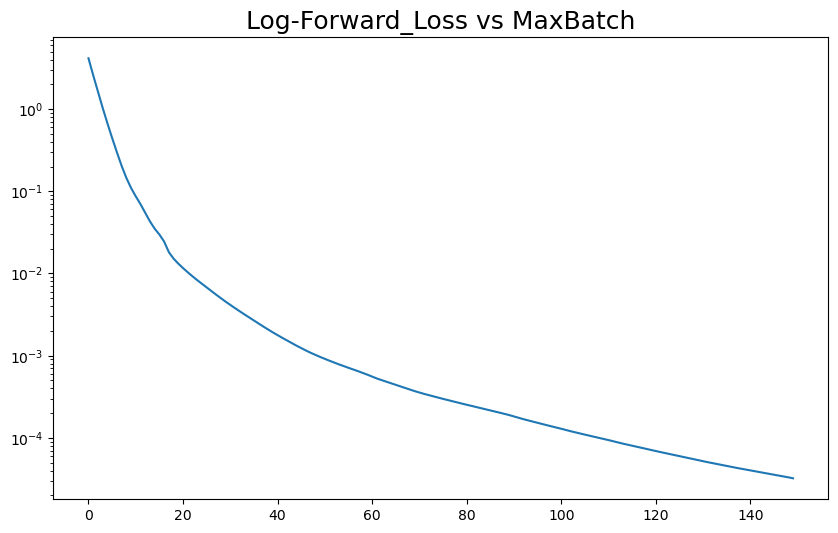

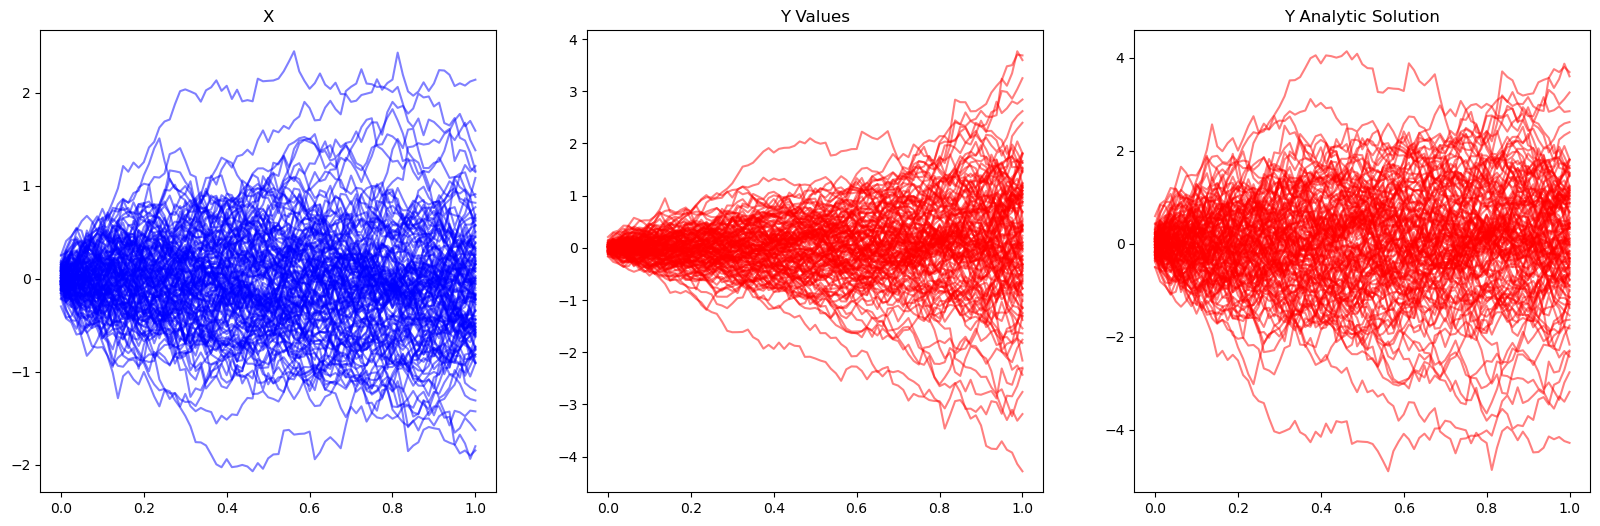

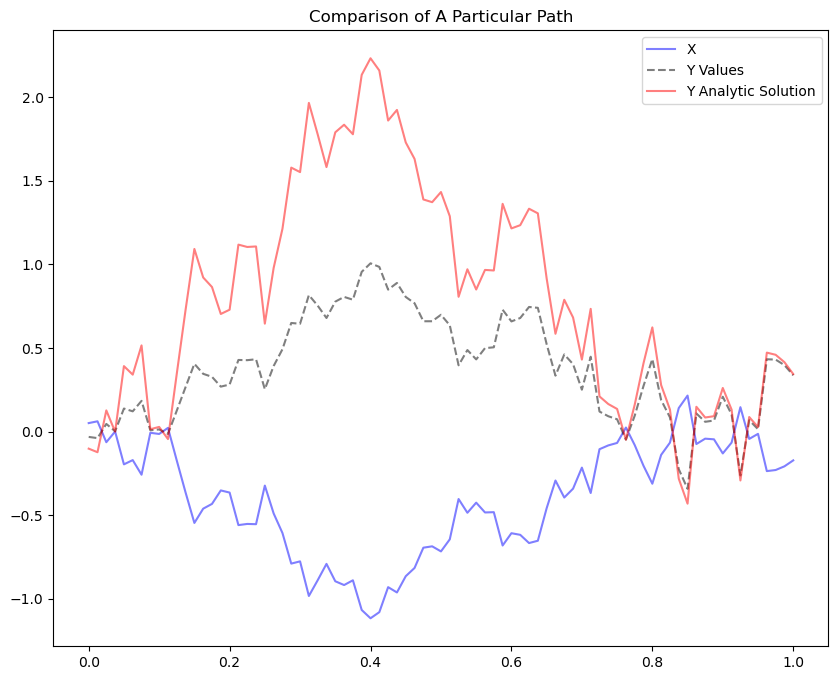

In [10]:
## Results

#Log-forward_loss
plt.figure(figsize=(10,6))
plt.title("Log-Forward_Loss vs MaxBatch",fontsize=18)
plt.plot(forward_losses)
plt.yscale('log')

x_path, y_path = get_target_path_coupled(dB, init_x, y0_model=y0_model_main, z_models=z_models_main, NumBM=NumTrain, NT=NT)
number_of_paths = np.minimum(128,NumTrain)
idx_list = np.random.choice(NumTrain, number_of_paths, replace = False)
x_plot = x_path.detach().numpy()[idx_list]
y_plot = y_path.detach().numpy()[idx_list]
y_plot_true=-g_prime(x_plot)
t = np.array([i for i in range(NT+1)]) * 1/(NT)

plt.figure(figsize=(20,6))
plt.subplot(131)
for i in range(number_of_paths):
        plt.plot(t,x_plot[i], color="blue", alpha=0.5)
plt.title("X")

plt.subplot(132)
for i in range(number_of_paths):
        plt.plot(t,y_plot[i], color="red", alpha=0.5)
plt.title("Y Values")

plt.subplot(133)
for i in range(number_of_paths):
        plt.plot(t,y_plot_true[i], color="red", alpha=0.5)
plt.title("Y Analytic Solution")


plt.figure(figsize=(10,8))
plt.subplot()
idx=10  ## index for the selected path for visualizatino
plt.plot(t,x_plot[idx], color="blue", alpha=0.5,label='X')
plt.plot(t,y_plot[idx], color="black", linestyle='--',alpha=0.5,label="Y Values")
plt.plot(t,y_plot_true[idx], color="red", alpha=0.5,label="Y Analytic Solution")
plt.title("Comparison of A Particular Path")
plt.legend()

## Couple And With Jump
>### Indicator Function

In [11]:
## Train 

def g_prime_Indicator(x):
    x=x.detach().numpy()
    indicator=np.where(x<0,-1,0)
    return torch.FloatTensor(indicator)

def Sample_Init(N):
    '''
    Generate N samples of x0
    '''
    xi = np.random.normal(0,0.1,size=N)

    return torch.FloatTensor(xi).view(-1,1)

def SampleBMIncr(T, Npaths, Nsteps):
    # Returns Matrix of Dimension Npaths x Nsteps With Sample Increments of of BM
    # Here an increment is of the form dB
    dt = T / Nsteps
    dB = np.sqrt(dt) * np.random.randn(Npaths, Nsteps)
    return torch.FloatTensor(dB)

def g_prime(x):
    gp =  2 * x   ## REVISE: NOT -2*x
    return gp

# Forward Loss
def get_foward_loss_coupled(dB, init_x,NT, gp,y0_model, z_models):
    x =  init_x
    y = y0_model(x)
    for j in range(1, NT+1):
 
        z = z_models[j-1](x)
        x = x  + y*dt+ dB[:,j].view(-1,1)
        y = y  + z * dB[:,j].view(-1,1)
    return torch.mean((y + gp(x))**2)   ## REVISE: target is -g_prime, so '+'


def get_target_path_coupled(dB, init_x,NumBM, NT,y0_model, z_models):
    x_path = torch.ones(NumBM,NT+1)
    y_path = torch.ones(NumBM,NT+1)
    x = init_x
    y = y0_model(x)
    x_path[:,0] = x.squeeze()
    y_path[:,0] = y.squeeze()
    for j in range(1, NT+1):
        z = z_models[j-1](x)
        x = x  + y*dt+dB[:,j].view(-1,1)
        y= y + z * dB[:,j].view(-1,1)
        x_path[:,j] = x.squeeze()
        y_path[:,j] = y.squeeze()
    return x_path.detach(), y_path.detach()


#Numbers
NumTrain=500
NT=80
dt=1/NT
dB = SampleBMIncr(1, Npaths=NumTrain, Nsteps=NT+1)
init_x =  Sample_Init(N=NumTrain)

#Set up main models for y0 and z (z will be list of models)
layer_dim = 10
y0_model_main = Network(lr=0.001, input_dims=[1], fc1_dims=layer_dim, fc2_dims=layer_dim,
                     n_outputs=1)
z_models_main = [Network(lr=0.001, input_dims=[1], fc1_dims=layer_dim, fc2_dims=layer_dim,
                     n_outputs=1) for i in range(NT)]

##Input Parameters for Optimization
forward_losses = []

#How many batches?
MaxBatch= 150

#How many optimization steps per batch
OptimSteps= 25

#Set Learning rate
learning_rate = 0.001

#Train on a single batch?
single_batch = True

#Set seed
random.seed(100)

#Define optimization parameters
params = list(y0_model_main.parameters())
for i in range(NT):
    params += list(z_models_main[i].parameters())
    
#Set up optimizer and scheduler
optimizer = optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.999)


for k in range(0,MaxBatch):

    print("Batch Number: ", k+1)
    sloss=0
    #optimize main network wrt the foward loss
    for l in range(0,OptimSteps):
        optimizer.zero_grad()

        loss = get_foward_loss_coupled(dB, init_x,NT=NT,gp=g_prime_Indicator, y0_model=y0_model_main, z_models=z_models_main)

        loss.backward()
        optimizer.step()
        scheduler.step()
        nloss = loss.detach().numpy()
        sloss += nloss
        # print('OptimStep: '+ str(l+1))
        # print('forward_loss: ' + str(nloss))
    avgloss = sloss/OptimSteps
    print("Average Error Est: ", avgloss)
    forward_losses.append(avgloss)

    #Generate a new batch if using multiple batches
    if(not single_batch):
        dB = SampleBMIncr(1, Npaths=NumTrain, Nsteps=NT+1)
        init_x =  Sample_Init(N=NumTrain)


Batch Number:  1
Average Error Est:  0.4265989291667938
Batch Number:  2
Average Error Est:  0.20497695446014405
Batch Number:  3
Average Error Est:  0.12292336791753769
Batch Number:  4
Average Error Est:  0.08580207467079162
Batch Number:  5
Average Error Est:  0.0677247029542923
Batch Number:  6
Average Error Est:  0.05872612223029137
Batch Number:  7
Average Error Est:  0.05244404450058937
Batch Number:  8
Average Error Est:  0.048100602626800534
Batch Number:  9
Average Error Est:  0.04450104862451553
Batch Number:  10
Average Error Est:  0.04210632085800171
Batch Number:  11
Average Error Est:  0.03996848985552788
Batch Number:  12
Average Error Est:  0.038177087903022766
Batch Number:  13
Average Error Est:  0.03700766980648041
Batch Number:  14
Average Error Est:  0.03512243717908859
Batch Number:  15
Average Error Est:  0.033860157728195193
Batch Number:  16
Average Error Est:  0.03304576888680458
Batch Number:  17
Average Error Est:  0.032099271342158314
Batch Number:  18
Ave

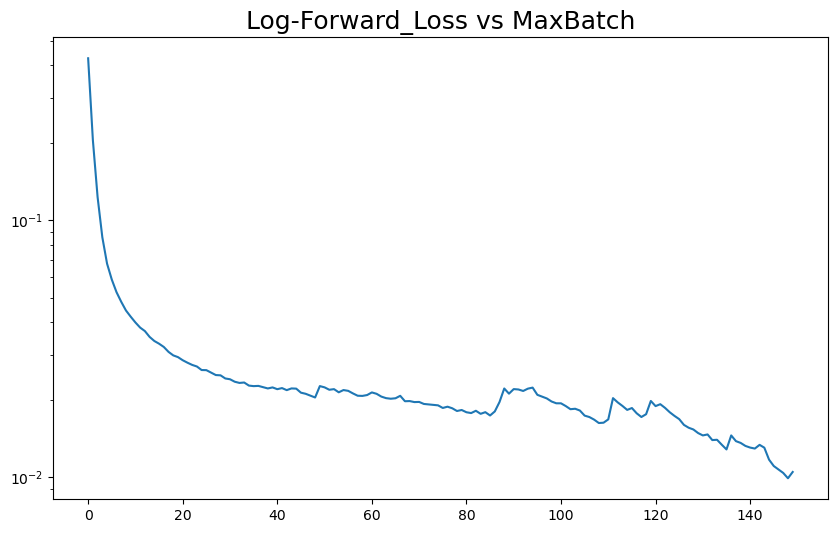

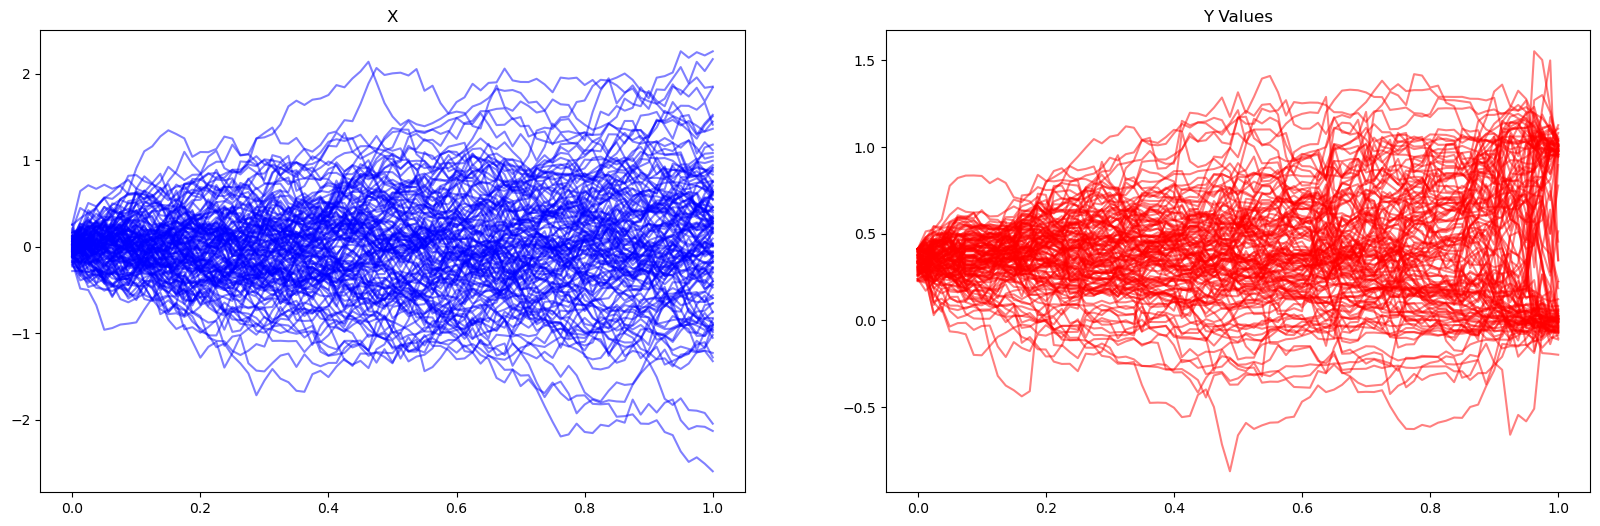

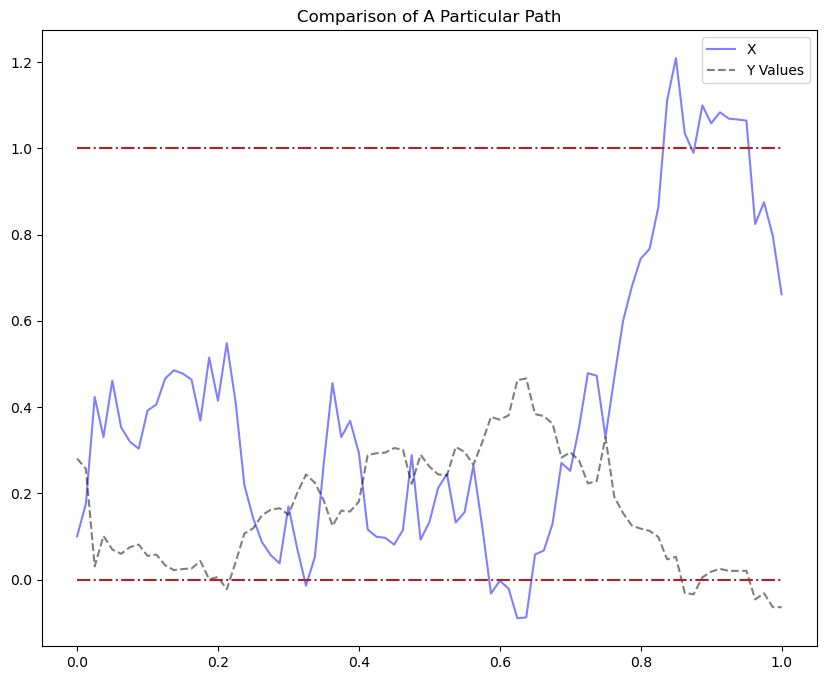

In [13]:
## Plot Results

#Log-forward_loss
plt.figure(figsize=(10,6))
plt.title("Log-Forward_Loss vs MaxBatch",fontsize=18)
plt.plot(forward_losses)
plt.yscale('log')

x_path, y_path = get_target_path_coupled(dB, init_x, y0_model=y0_model_main, z_models=z_models_main, NumBM=NumTrain, NT=NT)
# y_path_true=-g_prime_NegSigmoid(x_path)
number_of_paths = np.minimum(128,NumTrain)
idx_list = np.random.choice(NumTrain, number_of_paths, replace = False)
x_plot = x_path.detach().numpy()[idx_list]
# y_plot_true=y_path_true.detach().numpy()[idx_list]
y_plot = y_path.detach().numpy()[idx_list]

t = np.array([i for i in range(NT+1)]) * 1/(NT)

### Separate Plots
plt.figure(figsize=(20,6))
plt.subplot(121)
for i in range(number_of_paths):
        plt.plot(t,x_plot[i], color="blue", alpha=0.5)
plt.title("X")

plt.subplot(122)
for i in range(number_of_paths):
        plt.plot(t,y_plot[i], color="red", alpha=0.5)
plt.title("Y Values")

### Integrated Plots
plt.figure(figsize=(10,8))
plt.subplot()
idx=10  ## index for the selected path for visualization
plt.plot(t,x_plot[idx], color="blue", alpha=0.5,label='X')
plt.plot(t,y_plot[idx], color="black", linestyle='--',alpha=0.5,label="Y Values")
plt.hlines(y=[0,1],xmin=0,xmax=1,colors='firebrick',linestyles='-.')
plt.title("Comparison of A Particular Path")
plt.legend()

>### $\mathbb{R} \rightarrow [0, 1]$ with sigmoid 

In [59]:
## Train 

def target_NegSigmoid(x,sigma=0.005):
    '''
    To approaximate the indicator function: I{x<0}.
    The smaller sigma, the closer the approximation.
    '''
    x=x.detach().numpy()
    return torch.FloatTensor(1/(1+np.exp(x/sigma)))

def Sample_Init(N):
    '''
    Generate N samples of x0
    '''
    xi = np.random.normal(0,0.1,size=N)

    return torch.FloatTensor(xi).view(-1,1)

def SampleBMIncr(T, Npaths, Nsteps):
    # Returns Matrix of Dimension Npaths x Nsteps With Sample Increments of of BM
    # Here an increment is of the form dB
    dt = T / Nsteps
    dB = np.sqrt(dt) * np.random.randn(Npaths, Nsteps)
    return torch.FloatTensor(dB)

# Forward Loss
def get_foward_loss_coupled(dB, init_x,NT, target,y0_model, z_models):
    x =  init_x
    y = y0_model(x)
    for j in range(1, NT+1):
 
        z = z_models[j-1](x)
        x = x  + y*dt+ dB[:,j].view(-1,1)
        y = y  + z * dB[:,j].view(-1,1)
    return torch.mean((y -target(x))**2)   ## REVISE: target is -g_prime, so '+'

def get_target_path_coupled(dB, init_x,NumBM, NT,y0_model, z_models):
    x_path = torch.ones(NumBM,NT+1)
    y_path = torch.ones(NumBM,NT+1)
    x = init_x
    y = y0_model(x)
    x_path[:,0] = x.squeeze()
    y_path[:,0] = y.squeeze()
    for j in range(1, NT+1):
        z = z_models[j-1](x)
        x = x  + y*dt+dB[:,j].view(-1,1)
        y= y + z * dB[:,j].view(-1,1)
        x_path[:,j] = x.squeeze()
        y_path[:,j] = y.squeeze()
    return x_path.detach(), y_path.detach()

#Numbers
NumTrain=500
NT=80
dt=1/NT
dB = SampleBMIncr(1, Npaths=NumTrain, Nsteps=NT+1)
init_x =  Sample_Init(N=NumTrain)

#Set up main models for y0 and z (z will be list of models)
layer_dim = 10
y0_model_main = Network(lr=0.001, input_dims=[1], fc1_dims=layer_dim, fc2_dims=layer_dim,
                     n_outputs=1)
z_models_main = [Network(lr=0.001, input_dims=[1], fc1_dims=layer_dim, fc2_dims=layer_dim,
                     n_outputs=1) for i in range(NT)]

##Input Parameters for Optimization
forward_losses = []

#How many batches?
MaxBatch= 200

#How many optimization steps per batch
OptimSteps= 50

#Set Learning rate
learning_rate = 0.001

#Train on a single batch?
single_batch = True

#Set seed
random.seed(100)

#Define optimization parameters
params = list(y0_model_main.parameters())
for i in range(NT):
    params += list(z_models_main[i].parameters())
    
#Set up optimizer and scheduler
optimizer = optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.999)


for k in range(0,MaxBatch):

    print("Batch Number: ", k+1)
    sloss=0
    #optimize main network wrt the foward loss
    for l in range(0,OptimSteps):
        optimizer.zero_grad()

        loss = get_foward_loss_coupled(dB, init_x,NT=NT,target=target_NegSigmoid, y0_model=y0_model_main, z_models=z_models_main)

        loss.backward()
        optimizer.step()
        scheduler.step()
        nloss = loss.detach().numpy()
        sloss += nloss
        # print('OptimStep: '+ str(l+1))
        # print('forward_loss: ' + str(nloss))
    avgloss = sloss/OptimSteps
    print("Average Error Est: ", avgloss)
    forward_losses.append(avgloss)

    #Generate a new batch if using multiple batches
    if(not single_batch):
        dB = SampleBMIncr(1, Npaths=NumTrain, Nsteps=NT+1)
        init_x =  Sample_Init(N=NumTrain)


Batch Number:  1


/var/folders/xb/rvrt2lnd1bs3y0fbz2c5wbwm0000gn/T/ipykernel_1138/1273477288.py:9: RuntimeWarning: overflow encountered in exp
  return torch.FloatTensor(-1/(1+np.exp(x/sigma)))


Average Error Est:  0.5347419503331184
Batch Number:  2
Average Error Est:  0.12965135112404824
Batch Number:  3
Average Error Est:  0.06699644856154918
Batch Number:  4
Average Error Est:  0.0482362961024046
Batch Number:  5
Average Error Est:  0.04003315754234791
Batch Number:  6
Average Error Est:  0.03479971662163735
Batch Number:  7
Average Error Est:  0.030507230572402476
Batch Number:  8
Average Error Est:  0.027107726745307446
Batch Number:  9
Average Error Est:  0.02430067002773285
Batch Number:  10
Average Error Est:  0.02210885427892208
Batch Number:  11
Average Error Est:  0.020118837654590608
Batch Number:  12
Average Error Est:  0.01860092278569937
Batch Number:  13
Average Error Est:  0.017273317910730838
Batch Number:  14
Average Error Est:  0.016111524179577827
Batch Number:  15
Average Error Est:  0.015092361960560083
Batch Number:  16
Average Error Est:  0.014295073561370372
Batch Number:  17
Average Error Est:  0.013515932243317366
Batch Number:  18
Average Error Es

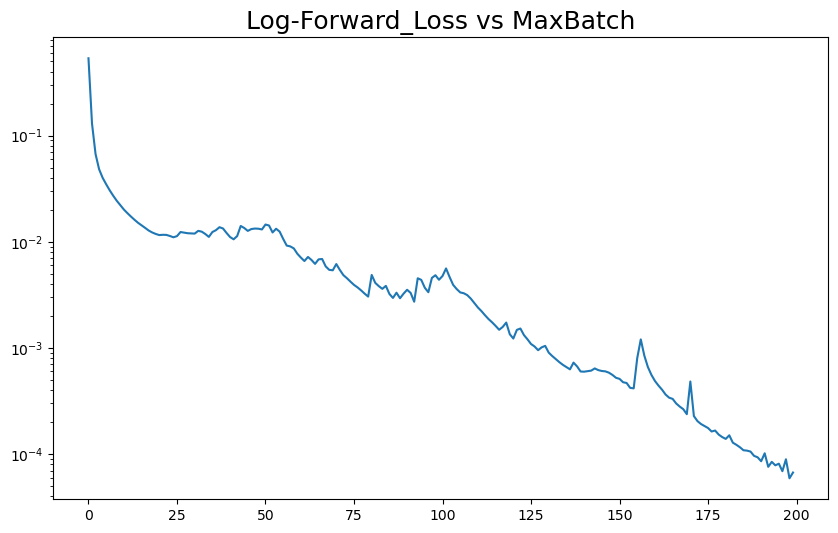

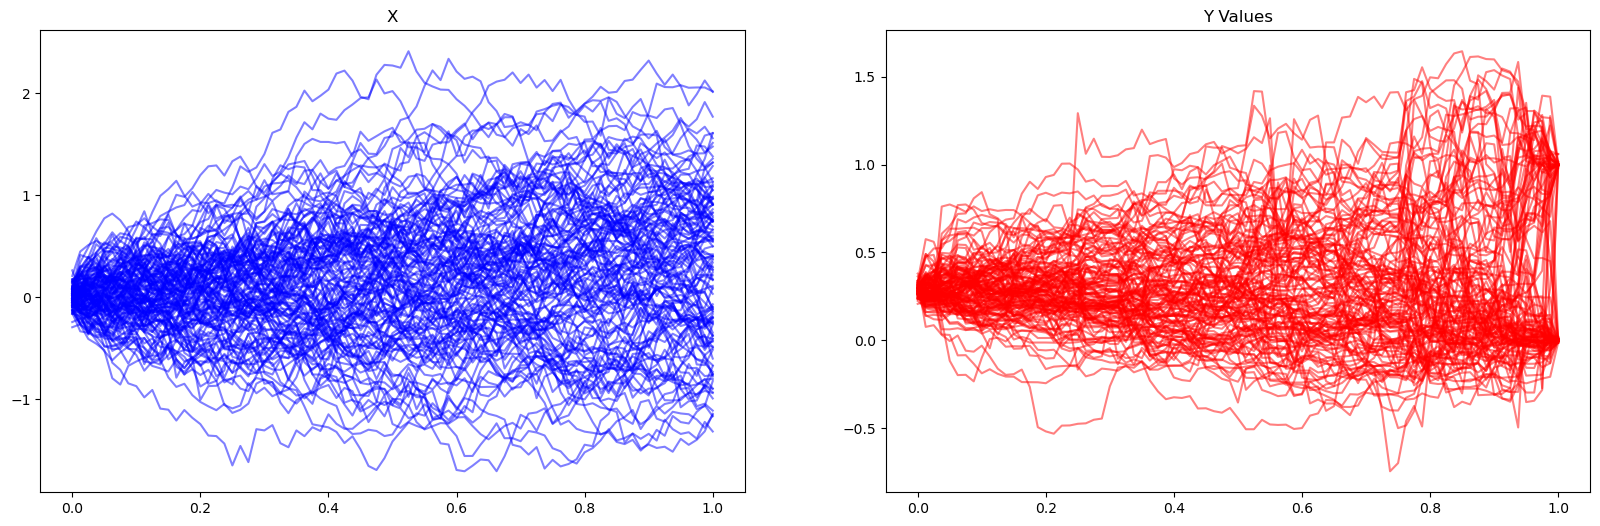

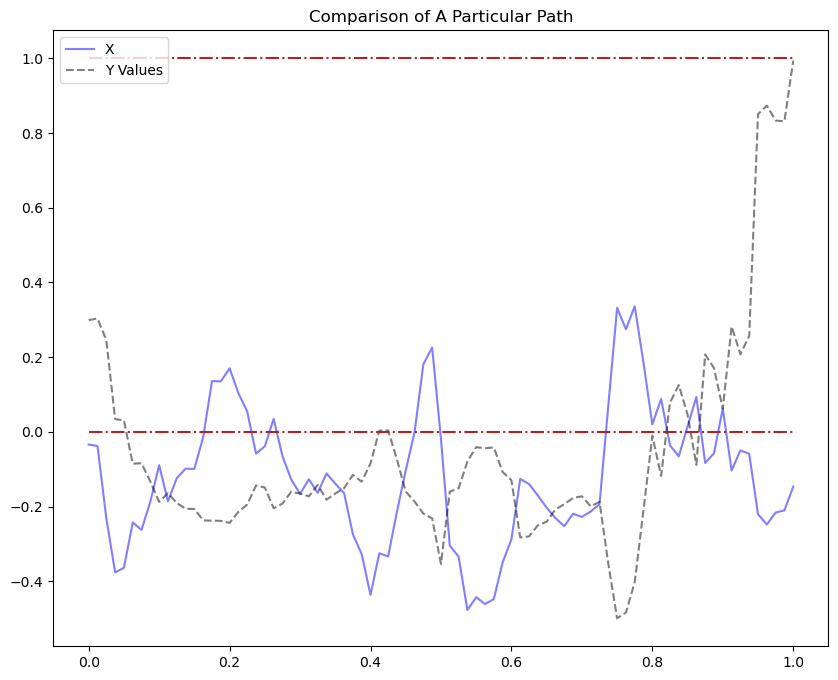

In [60]:
## Plot Results

#Log-forward_loss
plt.figure(figsize=(10,6))
plt.title("Log-Forward_Loss vs MaxBatch",fontsize=18)
plt.plot(forward_losses)
plt.yscale('log')
x_path, y_path = get_target_path_coupled(dB, init_x, y0_model=y0_model_main, z_models=z_models_main, NumBM=NumTrain, NT=NT)
number_of_paths = np.minimum(128,NumTrain)
idx_list = np.random.choice(NumTrain, number_of_paths, replace = False)
x_plot = x_path.detach().numpy()[idx_list]
y_plot = y_path.detach().numpy()[idx_list]

t = np.array([i for i in range(NT+1)]) * 1/(NT)

### Separate Plots
plt.figure(figsize=(20,6))
plt.subplot(121)
for i in range(number_of_paths):
        plt.plot(t,x_plot[i], color="blue", alpha=0.5)
plt.title("X")

plt.subplot(122)
for i in range(number_of_paths):
        plt.plot(t,y_plot[i], color="red", alpha=0.5)
plt.title("Y Values")

### Integrated Plots
idx=1
plt.figure(figsize=(10,8))
plt.subplot()
plt.plot(t,x_plot[idx], color="blue", alpha=0.5,label='X')
plt.plot(t,y_plot[idx], color="black", linestyle='--',alpha=0.5,label="Y Values")
plt.hlines(y=[0,1],xmin=0,xmax=1,colors='firebrick',linestyles='-.')
plt.title("Comparison of A Particular Path")
plt.legend()

>### $[0,1] \rightarrow \mathbb{R}$ with  $\tilde{Y}$
#### `Adam`
- The smallest `sigma` can be used (without any clip/clamp) is 0.05, with `MaxBatch`=1000, `OptimStep`=25
- When sigma=0.03, should impose `torch.nn.utils.clip_grad_norm_` with `max_norm`=1
- 


In [90]:
## Train 
torch.autograd.set_detect_anomaly(True)

def target(x,sigma=0.05):
    x=x.detach().numpy()
    return torch.FloatTensor(-x/sigma)

# Forward Loss
def get_foward_loss_coupled(dB, init_x,NT, target,y0_model, z_models):
    x =  init_x
    y_tilde=y0_model(x)
    y=torch.sigmoid(y_tilde)
    for j in range(1, NT+1):
 
        z = z_models[j-1](x)
        # print("Z_tilde Range:\n",min(z)," ~ ",max(z))
        x =x+ y*dt+ dB[:,j].view(-1,1)
        # print("X Range:\n",min(x)," ~ ",max(x))
        y_tilde = (y_tilde +(z**2)*(1-2/(1+torch.exp(y_tilde)))/2*dt  + z * dB[:,j].view(-1,1))#.clamp(min=-100,max=100)
        y=torch.sigmoid(y_tilde)
        
    
    loss=torch.mean((y_tilde-target(x))**2)
    
    return loss


def get_target_path_coupled(dB, init_x,NumBM, NT,y0_model, z_models):
    x_path = torch.ones(NumBM,NT+1)
    y_path = torch.ones(NumBM,NT+1)
    init_x =  Sample_Init(N=NumTrain)
    # y = torch.rand_like(x)
    y_tilde=y0_model(x)
    y=torch.sigmoid(y_tilde)
    x_path[:,0] = x.squeeze()
    y_path[:,0] = y.squeeze()
    for j in range(1, NT+1):
        z = z_models[j-1](x)
        x += y*dt+ dB[:,j].view(-1,1)
        y_tilde = (y_tilde +(z**2)*(1-2/(1+torch.exp(y_tilde)))/2 *dt + z * dB[:,j].view(-1,1))#.clamp(min=-1,max=1)
        # if y_tilde.isinf().any():
        #     print(y_tilde)
        y=torch.sigmoid(y_tilde)
        x_path[:,j] = x.squeeze()
        y_path[:,j] = y.squeeze()
    return x_path.detach(), y_path.detach()


#Numbers
NumTrain=700
NT=80
dt=1/NT
dB = SampleBMIncr(1, Npaths=NumTrain, Nsteps=NT+1)
init_x =  Sample_Init(N=NumTrain)
##Input Parameters for Optimization
forward_losses = []

#How many batches?
MaxBatch= 1000

#How many optimization steps per batch
OptimSteps= 25

#Set Learning rate
learning_rate = 0.001

#Train on a single batch?
single_batch = True

#Set up main models for y0 and z (z will be list of models)
layer_dim = 10
y0_model_main = Network(lr=learning_rate, input_dims=[1], fc1_dims=layer_dim, fc2_dims=layer_dim,
                     n_outputs=1)
z_models_main = [Network(lr=learning_rate, input_dims=[1], fc1_dims=layer_dim, fc2_dims=layer_dim,
                     n_outputs=1) for i in range(NT)]


#Define optimization parameters
# params = list(y0_model_main.parameters())
params=[]
for i in range(NT):
    params += list(z_models_main[i].parameters())
    
#Set up optimizer and scheduler
optimizer = optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=50,gamma=0.995)


for k in range(0,MaxBatch):

    print("Batch Number: ", k+1)
    sloss=0
    #optimize main network wrt the foward loss
    for l in range(0,OptimSteps):
        optimizer.zero_grad()

        loss = get_foward_loss_coupled(dB, init_x,NT=NT,target=target, y0_model=y0_model_main, z_models=z_models_main)
        # print(loss)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        nloss = loss.detach().numpy()
        sloss += nloss
        # print('OptimStep: '+ str(l+1))
        # print('forward_loss: ' + str(nloss))
    avgloss = sloss/OptimSteps
    print("Average Error Est: ", avgloss)
    forward_losses.append(avgloss)

    #Generate a new batch if using multiple batches
    if(not single_batch):
        dB = SampleBMIncr(1, Npaths=NumTrain, Nsteps=NT+1)
        init_x =  Sample_Init(N=NumTrain)


plot=plot_results(loss=forward_losses)
plot.FwdLoss()
plot.results()
plot.qq_plot()


Batch Number:  1
Average Error Est:  544.8693017578125
Batch Number:  2
Average Error Est:  504.90657470703127
Batch Number:  3
Average Error Est:  465.272353515625
Batch Number:  4
Average Error Est:  422.68003662109373
Batch Number:  5
Average Error Est:  374.55237060546875
Batch Number:  6
Average Error Est:  318.8876306152344
Batch Number:  7
Average Error Est:  256.4700402832031
Batch Number:  8
Average Error Est:  194.61520568847655
Batch Number:  9
Average Error Est:  150.43197021484374
Batch Number:  10
Average Error Est:  127.94175262451172
Batch Number:  11
Average Error Est:  114.40315734863282
Batch Number:  12
Average Error Est:  101.84412750244141
Batch Number:  13
Average Error Est:  92.42951751708985
Batch Number:  14
Average Error Est:  86.26606109619141
Batch Number:  15
Average Error Est:  80.92141784667969
Batch Number:  16
Average Error Est:  75.9697607421875
Batch Number:  17
Average Error Est:  72.25471343994141
Batch Number:  18
Average Error Est:  67.8679870605

UnboundLocalError: cannot access local variable 'x' where it is not associated with a value

$\because g(x)= \begin{cases} 0 \,\,\,, x>=q \\ q-x \,\,\, ,x<=q \end{cases}$   
$\therefore g'(x)= \begin{cases} 0 \,\,\,, x>=q \\ -1 \,\,\, ,x<=q \end{cases}  $     

In the previous cases, where the drfit of $X_t$ is $Y_t$:

$\therefore Y_T=-g'(X_T)= \begin{cases} 0 \,\,\,, X_T>=q \\ 1 \,\,\, ,X_T<=q \end{cases}  $

Take q=0, so when $X_T<=0\,\,,Y_T=1$; when $X_T>0\,\,,Y_T=0$, which can be approximated by a **flipped** sigmoid. 

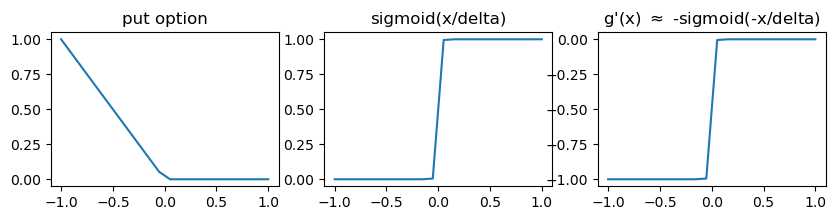

In [15]:
x=np.linspace(-1,1,20)
delta=0.01
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.title("put option")
plt.plot(x,np.where(x<=0,-x,0))

plt.subplot(132)
plt.title("sigmoid(x/delta)")
plt.plot(x,1/(1+np.exp(-x/delta)))

plt.subplot(133)
plt.title("g'(x) $\\approx$ -sigmoid(-x/delta)")
plt.plot(x,-1/(1+np.exp(x/delta)))
plt.show()

In this case:

$\text{drift}=h-(\frac{1}{\zeta}+\frac{1}{\gamma})Y_T^X+\frac{1}{\gamma}\mathbb{E}[Y_T^X]+C_T=-g'(X_T)= \begin{cases} 0 \,\,\,, X_T>=q \\ 1 \,\,\, ,X_T<=q \end{cases}  $

$\therefore Y_T^X=\frac{\zeta *\gamma}{\zeta+\gamma}(g'(X_T)+h+C_T+\frac{1}{\gamma}\mathbb{E}[Y_T^X])$